In [ ]:
import jax
import jax.numpy as jnp


from chewc.population import *
from chewc.sp import *
from chewc.trait import *

# Create founder population
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)



# Create population with 50 individuals, 1 chromosome, 1000 markers
pop, gen_map = msprime_pop(
    key=pop_key,
    n_ind=500,
    n_loci_per_chr=1000,
    n_chr=1,
    ploidy=2,
    effective_population_size=10_000,
    enforce_founder_maf = True,
    maf_threshold = .10,
    
)

# Create simulation parameters
sp = SimParam.from_founder_pop(pop, gen_map)

# Add a single additive trait with mean=0, var=1
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    founder_pop=pop,
    sim_param=sp,
    n_qtl_per_chr=50,  # Use 100 QTL per chromosome
    mean=jnp.array([0.0]),
    var=jnp.array([1.0])
)

print(f"Created population with {pop.nInd} individuals")
print(f"Genome: {sp.n_chr} chromosomes, {gen_map.shape[1]} markers per chromosome")
print(f"Added {sp.n_traits} trait(s) with {sp.traits.n_loci} QTL total")


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float, jaxtyped

# --- [PASTE THE ENTIRE CHEWC CODEBASE HERE] ---
# For brevity, I'm assuming the chewc functions (quick_haplo, SimParam,
# add_trait_a, make_cross, set_pheno, Population) are defined as you provided.

# --- GBLUP Implementation (from previous step) ---
@jax.jit
def run_gblup_with_pev(
    geno_dosage: Float[Array, "n_ind n_markers"],
    pheno: Float[Array, "n_ind 1"],
    h2: float
) -> tuple[Float[Array, ""], Float[Array, "n_ind"], Float[Array, "n_ind"], Float[Array, "n_ind"]]:
    """
    Performs a simple GBLUP analysis and calculates PEV and reliability.
    """
    n_ind, n_markers = geno_dosage.shape
    p = jnp.mean(geno_dosage, axis=0) / 2.0
    P = 2 * p
    Z = geno_dosage - P
    denominator = 2 * jnp.sum(p * (1 - p))
    G = (Z @ Z.T) / denominator
    epsilon = 1e-4
    G_reg = G + jnp.identity(n_ind) * epsilon
    G_inv = jnp.linalg.inv(G_reg)
    alpha = (1.0 - h2) / h2
    X = jnp.ones((n_ind, 1))
    lhs_top_left = X.T @ X
    lhs_top_right = X.T
    lhs_bottom_left = X
    lhs_bottom_right = jnp.identity(n_ind) + G_inv * alpha
    lhs_top = jnp.hstack([lhs_top_left, lhs_top_right])
    lhs_bottom = jnp.hstack([lhs_bottom_left, lhs_bottom_right])
    lhs = jnp.vstack([lhs_top, lhs_bottom])
    rhs_top = X.T @ pheno
    rhs_bottom = pheno
    rhs = jnp.concatenate([rhs_top.flatten(), rhs_bottom.flatten()])
    solutions = jnp.linalg.solve(lhs, rhs)
    mu_hat = solutions[0]
    gebv = solutions[1:]
    C_inv = jnp.linalg.inv(lhs)
    C22_inv = C_inv[1:, 1:]
    var_p = jnp.var(pheno)
    var_a = var_p * h2
    var_e = var_p * (1 - h2)
    pev = jnp.diag(C22_inv) * var_e
    reliability = jnp.maximum(0, 1 - (pev / var_a))
    return mu_hat, gebv, pev, reliability


Created population with 500 individuals
Genome: 1 chromosomes, 1000 markers per chromosome
Added 1 trait(s) with 50 QTL total


Created population with 500 individuals
Genome: 1 chromosomes, 1000 markers per chromosome
Added 1 trait(s) with 50 QTL total

Initial population stats:
  Mean BV: 2.060
  Var BV: 1.000
  Mean Pheno: 0.008
  Var Pheno: 3.671

STARTING 5-GENERATION BURN-IN

Generation 1:
  Selected 50 parents
  Mean BV: 3.045
  Var BV: 0.771
  Mean Phenotype: 0.900

Generation 2:
  Selected 50 parents
  Mean BV: 4.011
  Var BV: 0.619
  Mean Phenotype: 2.021

Generation 3:
  Selected 50 parents
  Mean BV: 4.901
  Var BV: 0.503
  Mean Phenotype: 2.933

Generation 4:
  Selected 50 parents
  Mean BV: 5.464
  Var BV: 0.413
  Mean Phenotype: 3.474

Generation 5:
  Selected 50 parents
  Mean BV: 6.021
  Var BV: 0.240
  Mean Phenotype: 4.020

PERFORMING GBLUP ANALYSIS

GBLUP Results:
  Fixed effect (intercept): 4.053
  Mean GEBV: -0.033
  SD GEBV: 4.130
  Mean PEV: 0.026042
  Mean Reliability: 0.892
  Correlation GEBV vs BV: 0.095

CREATING VISUALIZATIONS


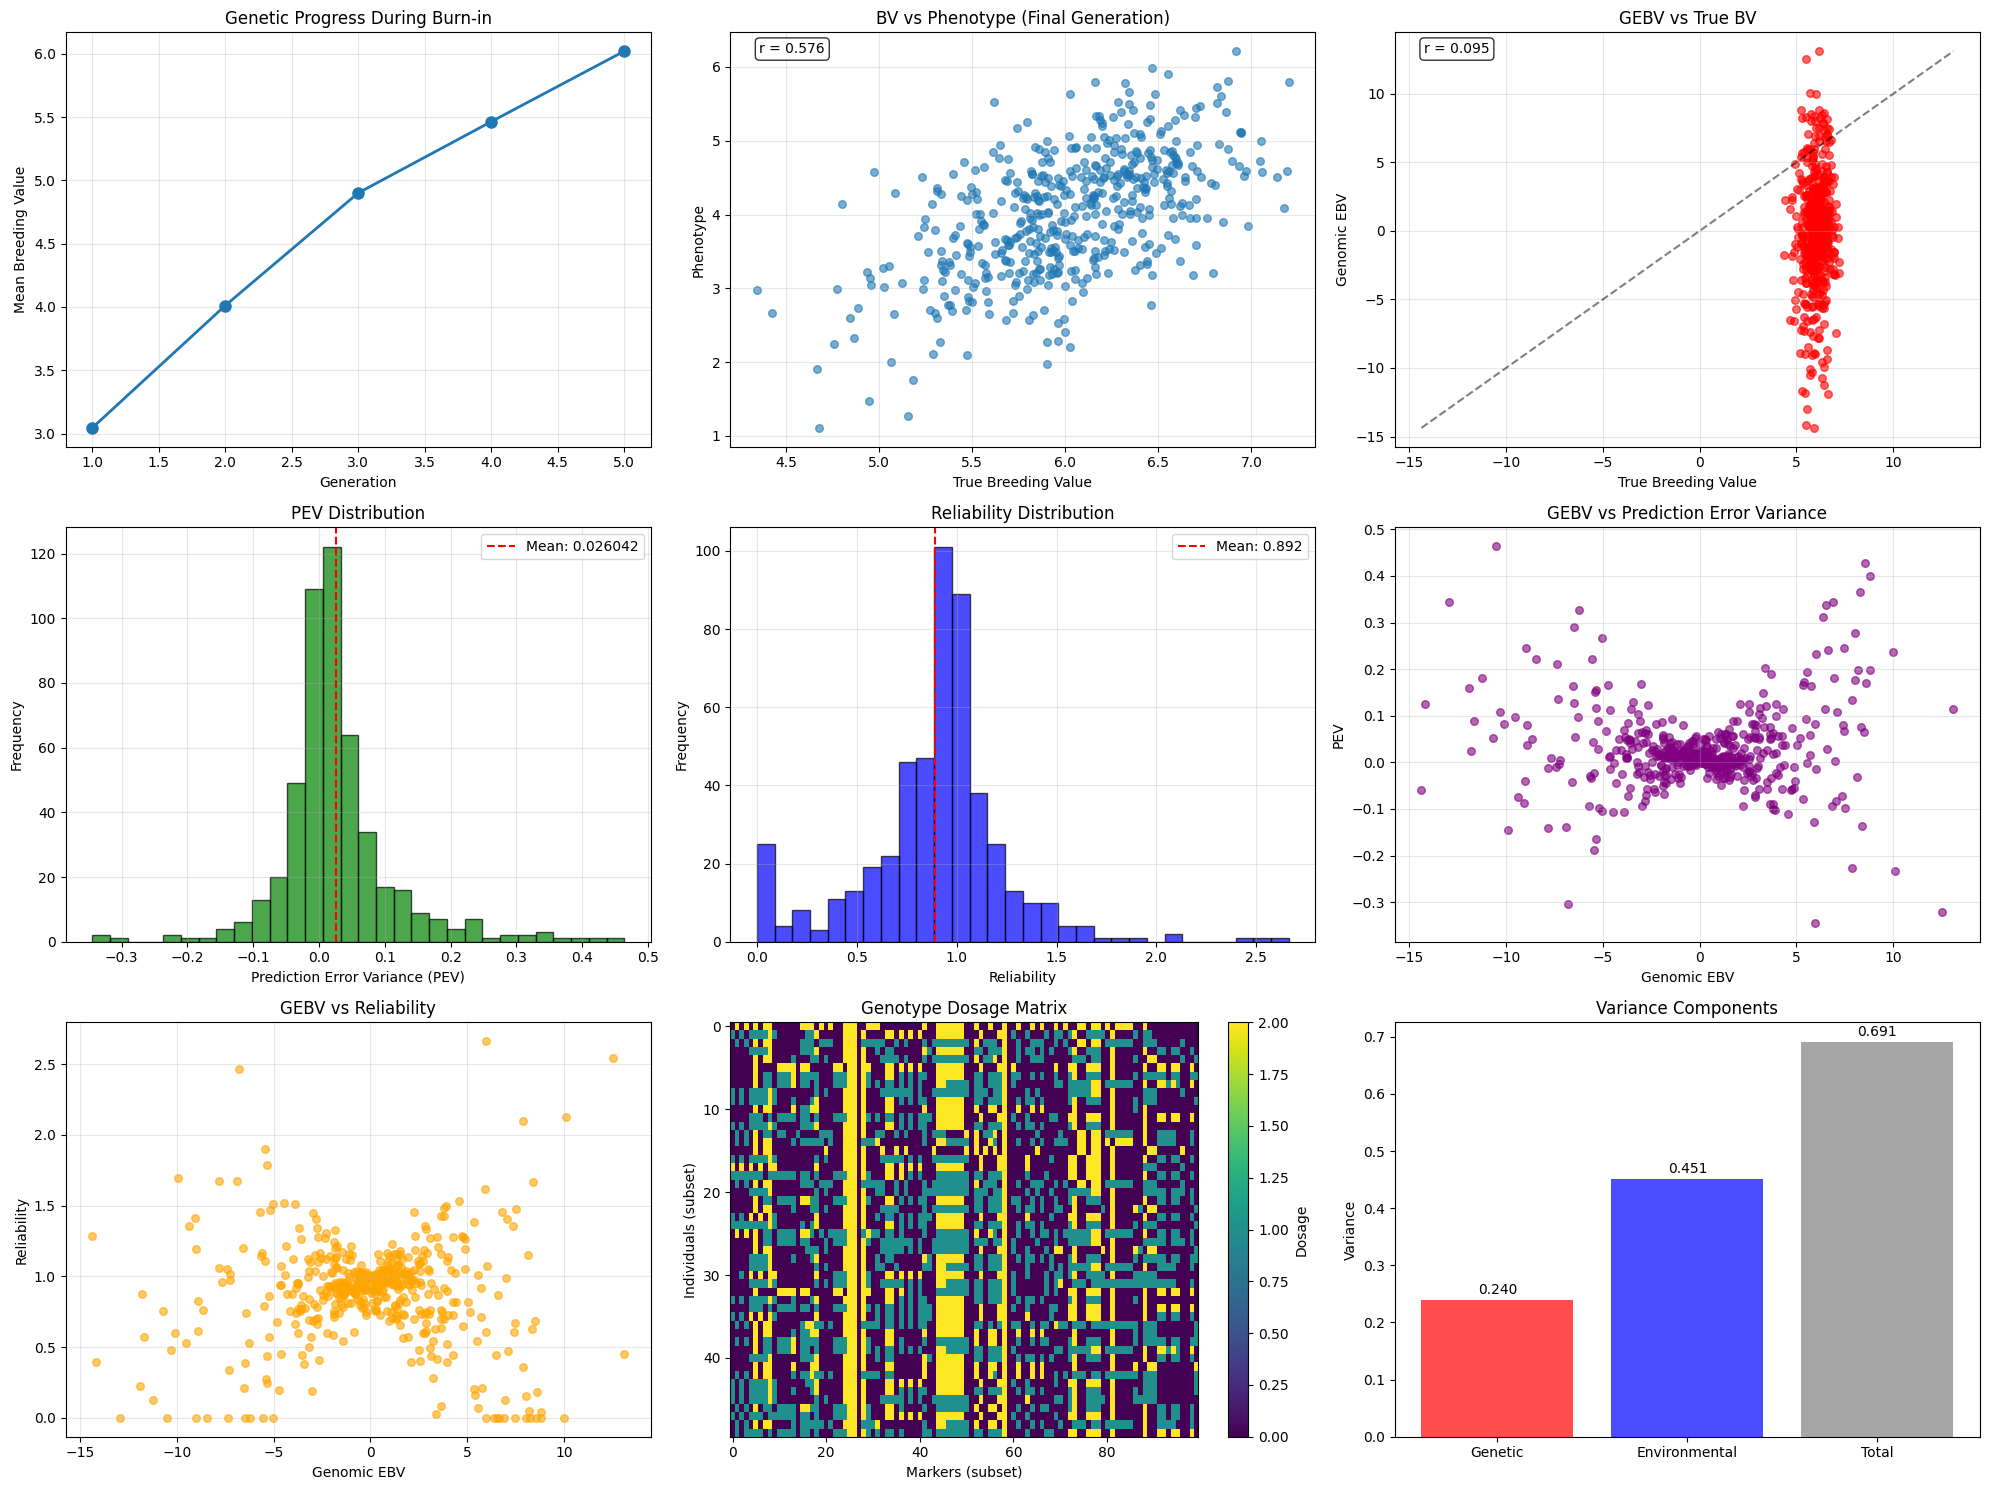


SIMULATION SUMMARY
Final population size: 500
Generations of burn-in: 5
Final mean breeding value: 6.021
Genetic gain per generation: 0.595
Successful GBLUP predictions: 500/500
Mean reliability: 0.892
GEBV-BV correlation: 0.095


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from jaxtyping import Array, Float

# Import your chewc modules
from chewc.population import *
from chewc.sp import *
from chewc.trait import *
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import PredictionResults

# ==================== GBLUP IMPLEMENTATION ====================

# ==================== SELECTION AND CROSSING FUNCTIONS ====================

def select_top_individuals(pop: Population, n_select: int, trait_idx: int = 0) -> jnp.ndarray:
    """Select top individuals based on phenotype."""
    pheno_values = pop.pheno[:, trait_idx]
    # Handle any NaN values
    valid_mask = ~jnp.isnan(pheno_values)
    if jnp.sum(valid_mask) < n_select:
        n_select = jnp.sum(valid_mask)
    
    valid_indices = jnp.where(valid_mask)[0]
    valid_phenos = pheno_values[valid_mask]
    
    # Get top individuals among valid ones
    top_valid_indices = jnp.argsort(valid_phenos)[-n_select:]
    return valid_indices[top_valid_indices]

def create_random_crosses(key: jax.random.PRNGKey, selected_indices: jnp.ndarray, n_crosses: int) -> jnp.ndarray:
    """Create random mating plan from selected individuals."""
    n_selected = len(selected_indices)
    
    # Sample mothers and fathers
    key1, key2 = jax.random.split(key)
    mothers = jax.random.choice(key1, selected_indices, shape=(n_crosses,), replace=True)
    fathers = jax.random.choice(key2, selected_indices, shape=(n_crosses,), replace=True)
    
    return jnp.column_stack([mothers, fathers])

# ==================== MAIN SIMULATION ====================

def run_burn_in_simulation():
    """Run the complete simulation with burn-in and GBLUP analysis."""
    
    # Set up initial population (using your provided code)
    key = jax.random.PRNGKey(42)
    key, pop_key = jax.random.split(key)

    # Create population with 500 individuals, 1 chromosome, 1000 markers
    pop, gen_map = msprime_pop(
        key=pop_key,
        n_ind=500,
        n_loci_per_chr=1000,
        n_chr=1,
        ploidy=2,
        effective_population_size=10_000,
        enforce_founder_maf=True,
        maf_threshold=0.10,
    )

    # Create simulation parameters
    sp = SimParam.from_founder_pop(pop, gen_map)

    # Add a single additive trait with mean=0, var=1
    key, trait_key = jax.random.split(key)
    sp = add_trait_a(
        key=trait_key,
        founder_pop=pop,
        sim_param=sp,
        n_qtl_per_chr=50,  # Use 50 QTL per chromosome
        mean=jnp.array([0.0]),
        var=jnp.array([1.0])
    )

    print(f"Created population with {pop.nInd} individuals")
    print(f"Genome: {sp.n_chr} chromosomes, {gen_map.shape[1]} markers per chromosome")
    print(f"Added {sp.n_traits} trait(s) with {sp.traits.n_loci} QTL total")

    # Set initial phenotypes
    key, pheno_key = jax.random.split(key)
    current_pop = set_pheno(
        key=pheno_key,
        pop=pop,
        traits=sp.traits,
        ploidy=sp.ploidy,
        h2=jnp.array([0.3])  # Heritability of 0.3
    )

    print(f"\nInitial population stats:")
    print(f"  Mean BV: {jnp.mean(current_pop.bv[:, 0]):.3f}")
    print(f"  Var BV: {jnp.var(current_pop.bv[:, 0]):.3f}")
    print(f"  Mean Pheno: {jnp.mean(current_pop.pheno[:, 0]):.3f}")
    print(f"  Var Pheno: {jnp.var(current_pop.pheno[:, 0]):.3f}")

    # Track breeding values over generations
    generation_stats = []
    
    # ==================== 5 GENERATION BURN-IN ====================
    print("\n" + "="*50)
    print("STARTING 5-GENERATION BURN-IN")
    print("="*50)
    
    current_id = sp.last_id
    
    for generation in range(5):
        print(f"\nGeneration {generation + 1}:")
        
        # Selection: top 50 individuals (10% selection intensity)
        selected_indices = select_top_individuals(current_pop, n_select=50, trait_idx=0)
        
        # Create crosses: 500 offspring from selected parents
        key, cross_key = jax.random.split(key)
        cross_plan = create_random_crosses(cross_key, selected_indices, n_crosses=500)
        
        # Make crosses
        key, mating_key = jax.random.split(key)
        offspring_pop = make_cross(
            key=mating_key,
            pop=current_pop,
            cross_plan=cross_plan,
            sp=sp,
            next_id_start=current_id
        )
        
        current_id += offspring_pop.nInd
        
        # Set phenotypes for offspring
        key, pheno_key = jax.random.split(key)
        offspring_pop = set_pheno(
            key=pheno_key,
            pop=offspring_pop,
            traits=sp.traits,
            ploidy=sp.ploidy,
            h2=jnp.array([0.3])
        )
        
        # Update current population
        current_pop = offspring_pop
        
        # Track statistics
        mean_bv = float(jnp.mean(current_pop.bv[:, 0]))
        var_bv = float(jnp.var(current_pop.bv[:, 0]))
        mean_pheno = float(jnp.mean(current_pop.pheno[:, 0]))
        
        generation_stats.append({
            'generation': generation + 1,
            'mean_bv': mean_bv,
            'var_bv': var_bv,
            'mean_pheno': mean_pheno,
            'n_ind': current_pop.nInd
        })
        
        print(f"  Selected {len(selected_indices)} parents")
        print(f"  Mean BV: {mean_bv:.3f}")
        print(f"  Var BV: {var_bv:.3f}")
        print(f"  Mean Phenotype: {mean_pheno:.3f}")

    # ==================== GBLUP ANALYSIS ====================
    print("\n" + "="*50)
    print("PERFORMING GBLUP ANALYSIS")
    print("="*50)
    
    # Fit GBLUP model
    try:
        prediction_results = gblup_predict(current_pop, h2=0.3, trait_idx=0)
        
        print(f"\nGBLUP Results:")
        print(f"  Fixed effect (intercept): {prediction_results.fixed_effects[0]:.3f}")
        print(f"  Mean GEBV: {jnp.nanmean(prediction_results.ebv[:, 0]):.3f}")
        print(f"  SD GEBV: {jnp.nanstd(prediction_results.ebv[:, 0]):.3f}")
        print(f"  Mean PEV: {jnp.nanmean(prediction_results.pev):.6f}")
        print(f"  Mean Reliability: {jnp.nanmean(prediction_results.reliability):.3f}")
        
        # Calculate correlation between GEBV and true BV
        valid_mask = ~jnp.isnan(prediction_results.ebv[:, 0])
        if jnp.sum(valid_mask) > 0:
            gebv_valid = prediction_results.ebv[valid_mask, 0]
            bv_valid = current_pop.bv[valid_mask, 0]
            correlation = float(jnp.corrcoef(gebv_valid, bv_valid)[0, 1])
            print(f"  Correlation GEBV vs BV: {correlation:.3f}")
    
    except Exception as e:
        print(f"GBLUP failed: {e}")
        prediction_results = None
        
    # ==================== VISUALIZATION ====================
    print("\n" + "="*50)
    print("CREATING VISUALIZATIONS")
    print("="*50)
    
    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 15))
    
    # Plot 1: Genetic progress over generations
    plt.subplot(3, 3, 1)
    generations = [s['generation'] for s in generation_stats]
    mean_bvs = [s['mean_bv'] for s in generation_stats]
    plt.plot(generations, mean_bvs, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Generation')
    plt.ylabel('Mean Breeding Value')
    plt.title('Genetic Progress During Burn-in')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: BV vs Phenotype correlation
    plt.subplot(3, 3, 2)
    plt.scatter(current_pop.bv[:, 0], current_pop.pheno[:, 0], alpha=0.6, s=30)
    plt.xlabel('True Breeding Value')
    plt.ylabel('Phenotype')
    plt.title('BV vs Phenotype (Final Generation)')
    
    # Calculate and display correlation
    bv_pheno_corr = float(jnp.corrcoef(current_pop.bv[:, 0], current_pop.pheno[:, 0])[0, 1])
    plt.text(0.05, 0.95, f'r = {bv_pheno_corr:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.grid(True, alpha=0.3)
    
    if prediction_results is not None:
        # Plot 3: GEBV vs True BV
        plt.subplot(3, 3, 3)
        valid_mask = ~jnp.isnan(prediction_results.ebv[:, 0])
        if jnp.sum(valid_mask) > 0:
            plt.scatter(current_pop.bv[valid_mask, 0], prediction_results.ebv[valid_mask, 0], 
                       alpha=0.6, s=30, color='red')
            plt.xlabel('True Breeding Value')
            plt.ylabel('Genomic EBV')
            plt.title('GEBV vs True BV')
            
            # Add diagonal line
            min_val = min(jnp.min(current_pop.bv[valid_mask, 0]), jnp.min(prediction_results.ebv[valid_mask, 0]))
            max_val = max(jnp.max(current_pop.bv[valid_mask, 0]), jnp.max(prediction_results.ebv[valid_mask, 0]))
            plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
            
            plt.text(0.05, 0.95, f'r = {correlation:.3f}', transform=plt.gca().transAxes, 
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        plt.grid(True, alpha=0.3)
        
        # Plot 4: PEV distribution
        plt.subplot(3, 3, 4)
        valid_pev = prediction_results.pev[~jnp.isnan(prediction_results.pev)]
        if len(valid_pev) > 0:
            plt.hist(valid_pev, bins=30, alpha=0.7, color='green', edgecolor='black')
            plt.xlabel('Prediction Error Variance (PEV)')
            plt.ylabel('Frequency')
            plt.title('PEV Distribution')
            plt.axvline(jnp.mean(valid_pev), color='red', linestyle='--', 
                       label=f'Mean: {jnp.mean(valid_pev):.6f}')
            plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 5: Reliability distribution
        plt.subplot(3, 3, 5)
        valid_rel = prediction_results.reliability[~jnp.isnan(prediction_results.reliability)]
        if len(valid_rel) > 0:
            plt.hist(valid_rel, bins=30, alpha=0.7, color='blue', edgecolor='black')
            plt.xlabel('Reliability')
            plt.ylabel('Frequency')
            plt.title('Reliability Distribution')
            plt.axvline(jnp.mean(valid_rel), color='red', linestyle='--', 
                       label=f'Mean: {jnp.mean(valid_rel):.3f}')
            plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 6: GEBV vs PEV
        plt.subplot(3, 3, 6)
        valid_mask = ~jnp.isnan(prediction_results.ebv[:, 0]) & ~jnp.isnan(prediction_results.pev)
        if jnp.sum(valid_mask) > 0:
            plt.scatter(prediction_results.ebv[valid_mask, 0], prediction_results.pev[valid_mask], 
                       alpha=0.6, s=30, color='purple')
            plt.xlabel('Genomic EBV')
            plt.ylabel('PEV')
            plt.title('GEBV vs Prediction Error Variance')
        plt.grid(True, alpha=0.3)
        
        # Plot 7: Reliability vs GEBV
        plt.subplot(3, 3, 7)
        valid_mask = ~jnp.isnan(prediction_results.ebv[:, 0]) & ~jnp.isnan(prediction_results.reliability)
        if jnp.sum(valid_mask) > 0:
            plt.scatter(prediction_results.ebv[valid_mask, 0], prediction_results.reliability[valid_mask], 
                       alpha=0.6, s=30, color='orange')
            plt.xlabel('Genomic EBV')
            plt.ylabel('Reliability')
            plt.title('GEBV vs Reliability')
        plt.grid(True, alpha=0.3)
    
    # Plot 8: Dosage matrix heatmap (subset)
    plt.subplot(3, 3, 8)
    # Show subset of dosage matrix for visualization
    n_ind_show = min(50, current_pop.nInd)
    n_markers_show = min(100, current_pop.dosage.shape[1])
    dosage_subset = current_pop.dosage[:n_ind_show, :n_markers_show]
    
    plt.imshow(dosage_subset, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Dosage')
    plt.xlabel('Markers (subset)')
    plt.ylabel('Individuals (subset)')
    plt.title('Genotype Dosage Matrix')
    
    # Plot 9: Variance components
    plt.subplot(3, 3, 9)
    if prediction_results is not None:
        var_p = float(jnp.var(current_pop.pheno[:, 0]))
        var_g = float(jnp.var(current_pop.bv[:, 0]))
        var_e = var_p - var_g
        
        components = ['Genetic', 'Environmental', 'Total']
        variances = [var_g, var_e, var_p]
        colors = ['red', 'blue', 'gray']
        
        plt.bar(components, variances, color=colors, alpha=0.7)
        plt.ylabel('Variance')
        plt.title('Variance Components')
        
        # Add values on bars
        for i, v in enumerate(variances):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print final summary
    print(f"\n" + "="*50)
    print("SIMULATION SUMMARY")
    print("="*50)
    print(f"Final population size: {current_pop.nInd}")
    print(f"Generations of burn-in: 5")
    print(f"Final mean breeding value: {float(jnp.mean(current_pop.bv[:, 0])):.3f}")
    print(f"Genetic gain per generation: {(float(jnp.mean(current_pop.bv[:, 0])) - generation_stats[0]['mean_bv']) / 5:.3f}")
    
    if prediction_results is not None:
        valid_predictions = jnp.sum(~jnp.isnan(prediction_results.ebv[:, 0]))
        print(f"Successful GBLUP predictions: {valid_predictions}/{current_pop.nInd}")
        print(f"Mean reliability: {float(jnp.nanmean(prediction_results.reliability)):.3f}")
        print(f"GEBV-BV correlation: {correlation:.3f}")
    
    return current_pop, prediction_results, generation_stats

# Run the simulation
if __name__ == "__main__":
    final_pop, gblup_results, stats = run_burn_in_simulation()